In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions as et
%matplotlib inline

In [2]:
Data = pd.read_excel('Data compilation.xlsx',sheetname='DataCompiled',skiprows=[0,1,2])

In [3]:
TreatmentList = Data.TrtNum.drop_duplicates().values
print('TreatmentList')
print(TreatmentList)
YearList = Data.YearSown.drop_duplicates().values
print('YearList')
print(YearList)
Factors = ['Cultivar','SowingDate','PlantPopn','PGRCanopyMgmtTrt']

MetaIndex = pd.MultiIndex.from_product([YearList, TreatmentList])
GrandIndex = pd.DataFrame(index = MetaIndex, columns = Factors)
GrandIndex.sort_index(inplace=True)

print('Null Combos')
for Year in YearList:
    for Treat in TreatmentList:
        Filter = (Data.YearSown == Year) & (Data.TrtNum == Treat)
        Indicies = Data.ix[Filter,Data.columns.isin(Factors)].drop_duplicates().values
        try:
            GrandIndex.ix[(Year,Treat)] = Indicies
        except:
            print(str(Year)+' '+str(Treat))

GrandIndex.dropna(how='all',inplace=True)

for Treat in GrandIndex.index:
    GrandIndex.ix[Treat,'SowingDate'] = GrandIndex.ix[Treat,'SowingDate'].to_datetime()

TreatmentList
[u'2a' u'2e' u'1a' u'1e' u'3a' u'3e' u'2c' u'1c' u'3c' u'1d' u'1b' u'2f'
 u'2d' u'2b' u'3b' u'3d' u'4a' u'4d' u'4b' u'4c']
YearList
[2013 2014 2015]
Null Combos
2013 4a
2013 4d
2013 4b
2013 4c
2014 2e
2014 1e
2014 3e
2014 2f
2015 2e
2015 1e
2015 3e
2015 2f


In [4]:
ValuesToZero = ['LeafNum',
'NumLeafTips',
'NumLigules',
'PercentSenescence',
'NumGreenLeaves',
'NumSenescingLeaves',
'NumDeadLeaves',
'TotalBiomass',
'TotalLeafBiomass',
'GreenLeafBiomass',
'DeadLeafBiomass',
'LAI',
'CorrLightInterception',
'CorrLAI',
'NDVI',
'NDVIHC',
'WDVI',
'NDVISC']

ZeroData = pd.DataFrame(index = GrandIndex.index, columns = Data.columns)
for treat in ZeroData.index:
    ZeroData.ix[treat,'SampleDate'] = GrandIndex.ix[treat,'SowingDate']
    ZeroData.ix[treat,'Cultivar'] = GrandIndex.ix[treat,'Cultivar']
    ZeroData.ix[treat,'SowingDate'] = GrandIndex.ix[treat,'SowingDate']
    ZeroData.ix[treat,'PlantPopn'] = GrandIndex.ix[treat,'PlantPopn']
    ZeroData.ix[treat,'PGRCanopyMgmtTrt'] = GrandIndex.ix[treat,'PGRCanopyMgmtTrt']
    ZeroData.ix[treat,'YearSown'] = treat[0]
    ZeroData.ix[treat,'TrtNum'] = treat[1]
    for val in ValuesToZero:
        ZeroData.ix[treat,val] = 0.0
for val in ValuesToZero:
    ZeroData.ix[:,val] = ZeroData.ix[:,val].convert_objects(convert_numeric=True)
ZeroData.reset_index(level=[0,1],inplace=True,drop=True)

C:\Users\cflhxb\AppData\Roaming\Python\Python27\site-packages\ipykernel\__main__.py:32: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [5]:
Data = Data.append(ZeroData)
Data.set_index('SampleDate',inplace=True)
filter = Data.YearSown == 2013
Data.ix[filter,'I/Io'] = Data.ix[filter,'CorrLightInterception']
filter = Data.YearSown != 2013
Data.ix[filter,'I/Io'] = Data.ix[filter,'NDVISC']

In [6]:
for Treat in GrandIndex.index:
    GrandIndex.ix[Treat,'SowingDate'] = GrandIndex.ix[Treat,'SowingDate'].strftime('%d-%b')

TreatmentOrder = ['SowingDate','Cultivar','PlantPopn','PGRCanopyMgmtTrt']
GrandIndex = GrandIndex[TreatmentOrder]

In [7]:
def MakeLabel(Treat):
    label = ''
    for level in Treat.index:
        label += str(Treat.ix[level]) + ' '
    return label

In [116]:
def SetDemarkers(Index):
    Colors = ['red','orange','blue','green']
    Markers = ['o','s','^','*']
    Sizes = [12,10,8,6,4,2]
    Demarkers = [Colors, Markers, Sizes]
    DemarkerIndex = []
    FactorNumber = 0
    for Fact in Index.columns:
        LevelList = GraphTreats.ix[:,Fact].drop_duplicates().values
        FactorLevels = LevelList.size
        LevelDemarkers = Demarkers[FactorNumber][0:FactorLevels]
        LevelPairs = pd.Series(data=LevelDemarkers, index=LevelList)
        DemarkerIndex.append(LevelPairs)
        FactorNumber +=1
    return DemarkerIndex

In [9]:
Data.columns

Index([              u'TrialCode',                u'YearSown',
                        u'Farmer',                u'Location',
                          u'Plot',           u'TrialCodePlot',
                        u'TrtNum',                   u'Block',
                      u'Cultivar',              u'SowingDate',
                     u'PlantPopn',                  u'PGRTrt',
                     u'PGRTiming',        u'PGRCanopyMgmtTrt',
                          u'NTrt',                u'ApproxGS',
                u'ReassessmentGS',                u'PlantNum',
                       u'LeafNum',             u'NumLeafTips',
                    u'NumLigules',                   u'ttFeb',
                         u'ttMar',                   u'ttApr',
               u'LeafPositionNum',            u'LeafPosition',
                    u'AvLeafSize',            u'AvLeafWeight',
                         u'AvSLA',       u'PercentSenescence',
                u'NumGreenLeaves',      u'NumSenescingL

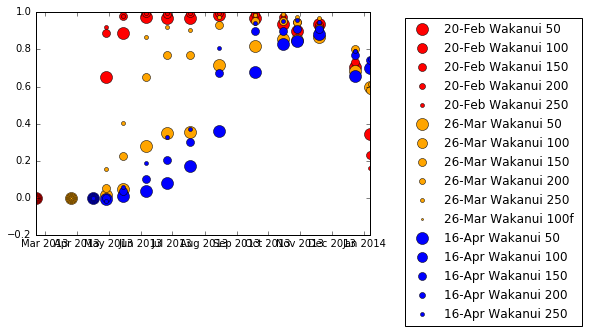

In [10]:
Year = 2013
GraphData = Data.ix[Data.YearSown==Year]
GraphTreats = GrandIndex.ix[Year,:].dropna(axis=1,how='all')
Demarkers = SetDemarkers(GraphTreats)

for Treat in GraphTreats.index:
    Filter = (Data.YearSown == Year) & (Data.TrtNum == Treat)
    GraphData = Data.ix[Filter,'CorrLightInterception'].dropna().groupby(level='SampleDate').mean()
    col = Demarkers[0][GraphTreats.ix[Treat][0]]
    mark = Demarkers[1][GraphTreats.ix[Treat][1]]
    try:
        size = Demarkers[2][GraphTreats.ix[Treat][2]]
    except:
        size = 8
    plt.plot(GraphData,mark,color = col, markersize = size,label = MakeLabel(GraphTreats.ix[Treat,:]))
plt.legend(bbox_to_anchor=(1.65, 1),numpoints=1)

In [11]:
MetData = pd.read_csv('LincolnClean.met',sep='\t')
MetData.set_index('Date', inplace=True)
MetData.index = MetData.index.to_datetime()
MetData.ix[:,'MeanT'] = np.divide(np.add(MetData.ix[:,'MinT'],MetData.ix[:,'MaxT']),2)
MetData.ix[:,'Tt'] = MetData.ix[:,'MeanT'].cumsum()

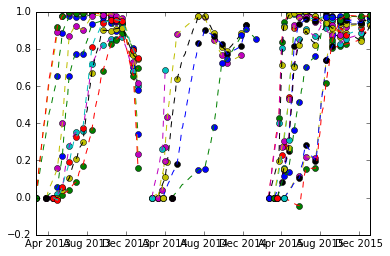

In [20]:
VarToInt = 'CorrLightInterception'
InterpolationIndex = pd.MultiIndex.from_product([YearList,TreatmentList,MetData.ix['2013-02-01':].index], names=['year', 'TrtNum', 'Date'])
BiomassAnalysis = pd.DataFrame(index = InterpolationIndex, columns=[VarToInt])
for Year in [2013,2014,2015]:
    YearData = Data.ix[Data.YearSown==Year,:]
    YearIndex = GrandIndex.ix[Year,:].dropna(axis=1,how='all')
    for Treat in YearIndex.index:
        Filter = YearData.TrtNum == Treat
        TreatCover = YearData.ix[Filter,VarToInt].dropna().groupby(level='SampleDate').mean()
        plt.plot(TreatCover,'o')
        Dates = TreatCover.index
        ArrayTt = MetData.ix[Dates,'Tt']
        InterpDates = MetData.ix[Dates.min():Dates.max()].index
        dailyTt = MetData.ix[InterpDates,'Tt']
        InterpCover = np.interp(dailyTt,ArrayTt,TreatCover)
        TreatIndex = pd.MultiIndex.from_product([Year,Treat,InterpDates],names=['Year', 'TrtNum', 'Date'])
        InterpDF = pd.DataFrame(index = TreatIndex, data=InterpCover,columns=[VarToInt])
        plt.plot(InterpDates, InterpDF.ix[:,VarToInt],'--')
        BiomassAnalysis.update(InterpDF)

In [21]:
BiomassAnalysis.dropna(inplace=True)

In [22]:
for Year in [2013,2014,2015]:
    YearData = Data.ix[Data.YearSown==Year,:]
    YearIndex = GrandIndex.ix[Year,:].dropna(axis=1,how='all')
    for Treat in YearIndex.index:
        Rad = MetData.ix[BiomassAnalysis.ix[(Year,Treat),:].index,'Radn']
        Temp = MetData.ix[BiomassAnalysis.ix[(Year,Treat),:].index,'MeanT']
        BiomassAnalysis.ix[(Year,Treat),'Radn'] = Rad.values
        BiomassAnalysis.ix[(Year,Treat),'Temp'] = Temp.values

In [23]:
BiomassAnalysis.ix[:,'IntRadn'] = BiomassAnalysis.ix[:,VarToInt] * BiomassAnalysis.ix[:,'Radn']
XTemp = [-10,0,15,25,35]
YRUE = [0,0,14,14,0]
BiomassAnalysis.ix[:,'RUE'] = [np.interp(BiomassAnalysis.ix[x,'Temp'],XTemp,YRUE) for x in BiomassAnalysis.index]
BiomassAnalysis.ix[:,'PotDM'] = BiomassAnalysis.ix[:,'RUE'] * BiomassAnalysis.ix[:,'IntRadn']

(array([ 735658.,  735689.,  735719.,  735750.,  735780.,  735811.,
         735842.,  735872.,  735903.,  735933.,  735964.,  735995.]),
 <a list of 12 Text xticklabel objects>)

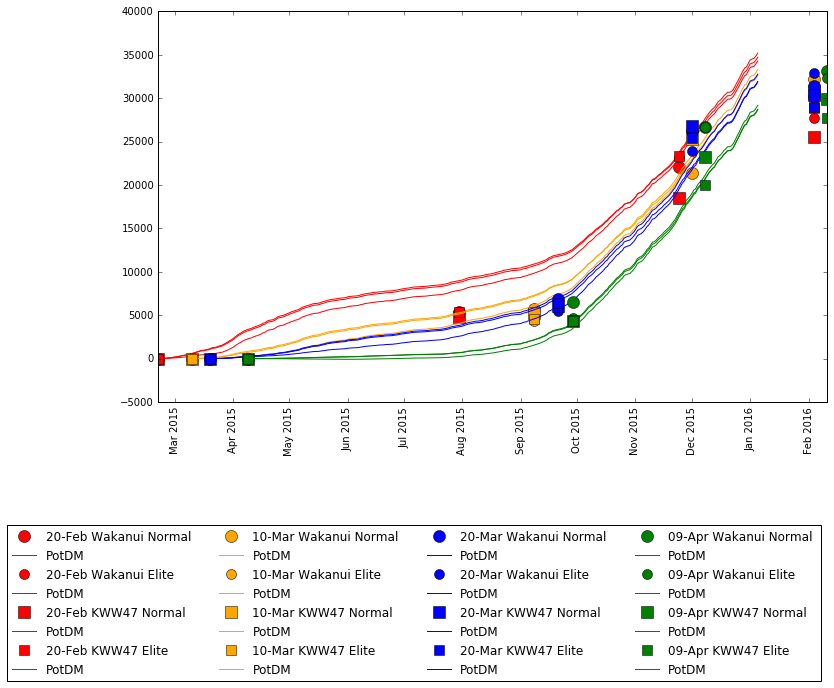

In [27]:
Year = 2015
GraphData = Data.ix[Data.YearSown==Year]
GraphTreats = GrandIndex.ix[Year,:].dropna(axis=1,how='all')
Demarkers = SetDemarkers(GraphTreats)
Graph = plt.figure(figsize=(12,7))

for Treat in GraphTreats.index:
    Filter = (Data.YearSown == Year) & (Data.TrtNum == Treat)
    GraphData = Data.ix[Filter,'TotalBiomass'].dropna().groupby(level='SampleDate').mean()
    col = Demarkers[0][GraphTreats.ix[Treat][0]]
    mark = Demarkers[1][GraphTreats.ix[Treat][1]]
    try:
        size = Demarkers[2][GraphTreats.ix[Treat][2]]
    except:
        size = 8
    plt.plot(GraphData,mark,color = col, markersize = size,label = MakeLabel(GraphTreats.ix[Treat,:]))
    Potbiomass = BiomassAnalysis.ix[(Year,Treat),'PotDM'].cumsum()
    plt.plot(Potbiomass,'-', color=col)
plt.legend(bbox_to_anchor=(1, -0.3),numpoints=1,ncol=4)
plt.xticks(rotation=90)

(array([ 734959.,  735081.,  735203.,  735324.,  735446.,  735568.,
         735689.,  735811.,  735933.]), <a list of 9 Text xticklabel objects>)

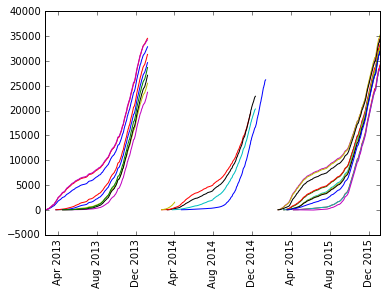

In [28]:
for Year in [2013,2014,2015]:
    GraphTreats = GrandIndex.ix[Year,:].dropna(axis=1,how='all')
    for Treat in GraphTreats.index:
        PotDM = BiomassAnalysis.ix[(Year,Treat),'PotDM'].cumsum()
        plt.plot(PotDM)
plt.xticks(rotation=90)

In [49]:
Data.columns

Index([              u'TrialCode',                u'YearSown',
                        u'Farmer',                u'Location',
                          u'Plot',           u'TrialCodePlot',
                        u'TrtNum',                   u'Block',
                      u'Cultivar',              u'SowingDate',
                     u'PlantPopn',                  u'PGRTrt',
                     u'PGRTiming',        u'PGRCanopyMgmtTrt',
                          u'NTrt',                u'ApproxGS',
                u'ReassessmentGS',                u'PlantNum',
                       u'LeafNum',             u'NumLeafTips',
                    u'NumLigules',                   u'ttFeb',
                         u'ttMar',                   u'ttApr',
               u'LeafPositionNum',            u'LeafPosition',
                    u'AvLeafSize',            u'AvLeafWeight',
                         u'AvSLA',       u'PercentSenescence',
                u'NumGreenLeaves',      u'NumSenescingL

In [65]:
Index = ['YearSown','SowingDate','Cultivar','PlantPopn','PGRCanopyMgmtTrt']
IndexedData = Data.set_index(Index)
IndexedData.sort_index(inplace=True)

In [201]:
IndexedData.columns

Index([              u'TrialCode',                  u'Farmer',
                      u'Location',                    u'Plot',
                 u'TrialCodePlot',                  u'TrtNum',
                         u'Block',                  u'PGRTrt',
                     u'PGRTiming',                    u'NTrt',
                      u'ApproxGS',          u'ReassessmentGS',
                      u'PlantNum',                 u'LeafNum',
                   u'NumLeafTips',              u'NumLigules',
                         u'ttFeb',                   u'ttMar',
                         u'ttApr',         u'LeafPositionNum',
                  u'LeafPosition',              u'AvLeafSize',
                  u'AvLeafWeight',                   u'AvSLA',
             u'PercentSenescence',          u'NumGreenLeaves',
            u'NumSenescingLeaves',           u'NumDeadLeaves',
                  u'TotalBiomass',           u'Grain0Percent',
                u'Grain14Percent',            u'StrawBi

C:\Users\cflhxb\AppData\Roaming\Python\Python27\site-packages\ipykernel\__main__.py:15: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


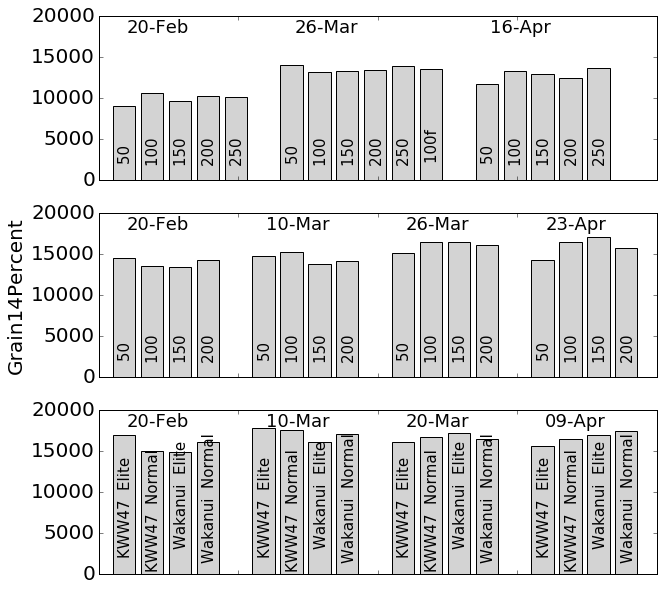

In [246]:
Variable = 'Grain14Percent'
Graph = plt.figure(figsize=(10,10))
pos=1
TreatInLabel = pd.Series(index = YearList, data = [[1],[1],[0,2]])
for Year in YearList:
    Pannel = Graph.add_subplot(3,1,pos)
    Max = np.percentile(pd.to_numeric(IndexedData.ix[:,Variable ].dropna()),95)
    Exponent = np.power(10,len(str(int(Max))))
    Yup = round(Max/Exponent,1)*Exponent
    plt.ylim(0,Yup)
    plt.tick_params(labelsize=20)
    Pannel.tick_params(labelbottom='off')
    if Year == 2014:
        plt.ylabel(Variable, fontsize = 20)
    GraphData = IndexedData.ix[Year,Variable ].dropna().convert_objects(convert_numeric=True)
    MeanData = GraphData.groupby(GraphData.index).mean()
    #plt.plot(GraphData)
    Left = 0
    count = 0
    LastSowIndex = MeanData.index[count][0]
    for Treat in MeanData.index:
        SowLab = MeanData.index[count][0].to_datetime().strftime('%d-%b')
        if count == 0:
            plt.text(Left+1,Yup*0.9,SowLab,fontsize=18)
        if LastSowIndex != MeanData.index[count][0]:
            Left+=1
            plt.text(Left+1,Yup*0.9,SowLab,fontsize=18)
        plt.bar(left=Left+.5,height=MeanData[count],color='lightgrey')
        FullLab = MeanData.index[count][1:]
        forShort = TreatInLabel[Year]
        LabMembers = [FullLab[i] for i in forShort]
        Label = ''
        for member in LabMembers:
            Label += str(member)
            Label += '  '
        height = Yup * len(Label)/20
        plt.text(Left+.7,height, Label,rotation=90, fontsize=15)
        Left += 1
        LastSowIndex = MeanData.index[count][0]
        count += 1
    pos +=1
#IndexedData.Grain0Percent.dropna().plot()